In [1]:
from lusidtools.jupyter_tools import toggle_code

"""Loading and caculating returns

Demonstration of how to get aggregate returns adjusted by FX performance

Attributes
----------
Returns
Composite portfolios
FX performance
"""

toggle_code("Toggle Docstring")

In [2]:
# %load_ext lab_black
# %load_ext nb_black

# 1. Loading and calculating composite returns in LUSID

In this notebook we show how composite returns can be adjusted for FX rates where there is a difference in base currency between a composite and its child portfolios. For the purposes of this example we consider a USD composite which tracks a GBP portfolio only throughout January 2020. We show that the GBP portfolio performs slightly better throughout Jan (due to FX rates) even though both portfolios have exposure to the exact same underlying assets.

# 2. Setup

In [3]:
# Import general purpose packages
import os
import json
import pandas as pd
import numpy as np
import datetime
import pytz
import warnings

warnings.filterwarnings("ignore", module="matplotlib*")

import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from pandas import json_normalize

# Import lusid specific packages
import lusid
import lusid.models as models

from lusid.utilities import ApiClientFactory
from lusidjam.refreshing_token import RefreshingToken

# Set display configuration
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 3500)
pd.set_option("max_colwidth", 20)

# Use line magic function to enable matplotlib to work interactively with iPython
%matplotlib inline

# Set style to fivethirtyeight to create clean and clear looking graphs
plt.style.use("fivethirtyeight")

# Define a dictionary containing default plotting configurations
params = {
    "legend.fontsize": "small",
    "figure.figsize": (12, 4.5),
    "axes.labelsize": "small",
    "axes.titlesize": "medium",
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
}

plt.rcParams.update(params)

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

# Initiate an API Factory which is the client side object for interacting with LUSID APIs
api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename=secrets_path,
    app_name="LusidJupyterNotebook",
)

api_status = pd.DataFrame(
    api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().to_dict()
)

display(api_status)

,api_version,build_version,excel_version,links
0,v0,0.6.8916.0,0.5.2721,{'relation': 'Re...


In [4]:
# Define a scope to hold data

scope = "CompositeFxDemo"

In [5]:
# define the two portfolios

portfolio_codes = [("ukEquity", "GBP"), ("composite", "USD")]

equity_portfolio, composite_portfolio = (
    portfolio_codes[0][0],
    portfolio_codes[1][0],
)

In [6]:
# Define the APIs we use

transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
portfolios_api = api_factory.build(lusid.api.PortfoliosApi)
properties_api = api_factory.build(lusid.api.PropertyDefinitionsApi)
relationship_definition_api = api_factory.build(lusid.api.RelationshipDefinitionsApi)
relationships_api = api_factory.build(lusid.api.RelationshipsApi)
quotes_api = api_factory.build(lusid.api.QuotesApi)
configuration_recipe_api = api_factory.build(lusid.api.ConfigurationRecipeApi)

# 3. Portfolio and relationships setup

In this section we create two portfolios and a relationship between them.

## 3.1 Create two portfolios

1. UK Equity Portfolio (base currency = GBP)
2. [Composite Portfolio](https://support.lusid.com/knowledgebase/article/KA-01730/en-us) (base currency = USD)

In [7]:
for port, base_currency in portfolio_codes:

    try:

        response = transaction_portfolios_api.create_portfolio(
            scope=scope,
            create_transaction_portfolio_request=models.CreateTransactionPortfolioRequest(
                display_name=port,
                code=port,
                created="2019-12-31",
                base_currency=base_currency,
            ),
        )
    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])

Could not create a portfolio with id 'ukEquity' because it already exists in scope 'CompositeFxDemo'.
Could not create a portfolio with id 'composite' because it already exists in scope 'CompositeFxDemo'.


## 3.2 Create a relationship definition

In this section we create a relationship between the GBP parent portfolio, which "holds" the returns, and a composite portfolio which tracks the returns of the parent portfolio (i.e. the "GBP portfolio"). The composite portfolio has a base currency of USD which effectively allows us to get the USD adjusted returns of the parent portfolio.  

> Important: This `CompositeMembership` relationship must be created in the `default` scope if you want to create a composite relationship in LUSID.

In [8]:
relationship_scope = "default"
relationship_code = "CompositeMembership"

In [9]:
try:

    relationship_definition_api.create_relationship_definition(
        create_relationship_definition_request=models.CreateRelationshipDefinitionRequest(
            scope=relationship_scope,
            code=relationship_code,
            source_entity_type="Portfolio",
            target_entity_type="Portfolio",
            display_name="Relationship for Composite Returns",
            outward_description="Relationship for Composite Returns",
            inward_description="Relationship for Composite Returns",
            life_time="TimeVariant",
        )
    )

except lusid.ApiException as e:
    print(json.loads(e.body)["title"])

Access cannot be granted


## 3.3 Create relationship between the composite and investment portfolio effective from 12 Dec 2019

In this section we create a [Relationship](https://support.lusid.com/knowledgebase/article/KA-01679/en-us) which forms the link between the GBP investment portfolio and the USD composite.

In [10]:
create_relationship_response = relationships_api.create_relationship(
    scope=relationship_scope,
    code=relationship_code,
    create_relationship_request=models.CreateRelationshipRequest(
        source_entity_id={"scope": scope, "code": composite_portfolio},
        target_entity_id={"scope": scope, "code": equity_portfolio},
        effective_from="2019-12-31",
    ),
)

# 4. Load returns and FX data

In this section we load returns data into the returns store and fx price data into the quotes store. Both sets of data are loaded from CSV files.

## 4.1 Load returns from CSV file into DataFrame

In [11]:
returns_df = pd.read_csv(
    "data/multi-currency-returns/returns.csv", dtype={"daily_returns": np.int64}
)
returns_df["date"] = pd.to_datetime(returns_df["date"], format="%d/%m/%Y")
returns_df = returns_df.rename(
    columns={"mv": "market_value", "returns": "daily_returns"}
)

## 4.2 Load returns from DataFrame into LUSID

In [12]:
from_effective_at = "2020-01-01"
to_effective_at = "2020-01-31"
return_code = "daily_return"
list_of_portfolios = [equity_portfolio, composite_portfolio]
recipe_code = "FxRates"
returns_df["portfolio"] = equity_portfolio

In [13]:
returns_df.head(5)

,portfolio,date,market_value,daily_returns
0,ukEquity,2020-01-01,1000000,-0.00907
1,ukEquity,2020-01-02,1006028,0.00603
2,ukEquity,2020-01-03,1002436,-0.00357
3,ukEquity,2020-01-06,1010355,0.00790
4,ukEquity,2020-01-07,1013281,0.00290


In [14]:
for portfolio, df in [(equity_portfolio, returns_df)]:

    time_series_of_returns = [
        models.PerformanceReturn(
            effective_at=row["date"].isoformat()[:10],
            rate_of_return=row["daily_returns"],
            opening_market_value=row["market_value"],
            period="Daily",
        )
        for _, row in df.iterrows()
    ]

    upsert_returns = portfolios_api.upsert_portfolio_returns(
        scope=scope,
        code=portfolio,
        return_code=return_code,
        return_scope=scope,
        performance_return=time_series_of_returns,
    )

## 4.3 Upload FX rates

In [15]:
fx_df = pd.read_csv("data/multi-currency-returns/fx-rates.csv")
fx_df["date"] = pd.to_datetime(fx_df["date"], format="%d/%m/%Y")


fx_rates = {
    f"upsert_request_{row['date']}": models.UpsertQuoteRequest(
        quote_id=models.QuoteId(
            quote_series_id=models.QuoteSeriesId(
                provider="Lusid",
                instrument_id="GBP/USD",
                instrument_id_type="CurrencyPair",
                quote_type="Price",
                field="mid",
            ),
            effective_at=row["date"].isoformat()[:10] + "T18:00:00Z",
        ),
        metric_value=models.MetricValue(value=row["gbp_usd_fx"], unit="USD"),
    )
    for _, row in fx_df.iterrows()
}


# Upsert the quotes into LUSID
response = quotes_api.upsert_quotes(scope=scope, request_body=fx_rates)

## 4.4 Create recipe for FX rates

Here we create a recipe which can read the quotes uploaded in the previous section.

In [16]:
# Create a recipe to perform a valuation

recipes = [(recipe_code, scope)]

for recipe_code, data_scope in recipes:

    configuration_recipe = models.ConfigurationRecipe(
        scope=scope,
        code=recipe_code,
        market=models.MarketContext(
            market_rules=[
                models.MarketDataKeyRule(
                    key="FX.CurrencyPair.*",
                    supplier="Lusid",
                    data_scope=data_scope,
                    quote_type="Price",
                    field="mid",
                ),
            ],
        ),
    )

    upsert_configuration_recipe_response = configuration_recipe_api.upsert_configuration_recipe(
        upsert_recipe_request=models.UpsertRecipeRequest(
            configuration_recipe=configuration_recipe
        )
    )

    print(f"Uploaded recipe: {recipe_code}")

Uploaded recipe: FxRates


# 5. Get returns out of LUSID

In this section we get the returns for the investment and composite portfolio and plot them against each other for January 2020.

## 5.1 Call a table of returns data for our two portfolios 

The linked [support page](https://support.lusid.com/knowledgebase/article/KA-01675/en-us) contains details on configuring different returns metrics.

In [17]:
since = "YYYY-12-31"

In [18]:
def get_returns_since_inception(portfolio_code):

    returns = portfolios_api.get_portfolio_aggregate_returns(
        scope=scope,
        code=portfolio_code,
        return_scope=scope,
        return_code=return_code,
        recipe_id_code="FxRates",
        recipe_id_scope=scope,
        from_effective_at=from_effective_at,
        to_effective_at=to_effective_at,
        period="Daily",
        output_frequency="Daily",
        metrics=[f"SINCE({since})"],
    )

    return returns

In [19]:
all_summary_df = pd.DataFrame(columns=["effective_at", f"metrics_value.SINCE({since})"])


for portfolio in list_of_portfolios:

    portfolio_summary_df = pd.DataFrame(
        columns=["effective_at", f"metrics_value.SINCE({since})"]
    )

    returns = get_returns_since_inception(portfolio)

    for item in returns.values:

        normalize_json = json_normalize(item.to_dict())
        normalize_json = normalize_json.set_index("effective_at").copy()
        portfolio_summary_df = portfolio_summary_df.append(normalize_json)

    all_summary_df = all_summary_df.join(
        portfolio_summary_df, rsuffix=f"{portfolio}", on="effective_at", how="outer"
    )

## 5.1 Format and clean returns results data

In [20]:
summary_columns = {
    f"metrics_value.SINCE({since})ukEquity": "ukEquity_GBP",
    f"metrics_value.SINCE({since})composite": "composite_USD",
}

In [21]:
all_summary_df = (
    all_summary_df[list(summary_columns.keys())].rename(columns=summary_columns).copy()
)

In [22]:
all_summary_df.head(5)

,ukEquity_GBP,composite_USD
2020-01-01 00:00:00+00:00,-0.00907,-0.00907
2020-01-02 00:00:00+00:00,-0.00310,0.00822
2020-01-03 00:00:00+00:00,-0.00665,0.00369
2020-01-06 00:00:00+00:00,0.00119,0.00417
2020-01-07 00:00:00+00:00,0.00409,0.00152


## 5.2 Plot the results in a time series

In [23]:
def time_series_performance():
    ts_performance = all_summary_df.plot(
        y=["ukEquity_GBP", "composite_USD"], figsize=(12, 9)
    )
    ts_performance.set_title(
        f"Performance since 2020-01-01", fontsize="large",
    )
    ts_performance.set_ylabel("Performance in %", fontsize="large")
    ts_performance.set_xlabel("Days", fontsize="large")
    ts_performance.legend(prop={"size": 12})

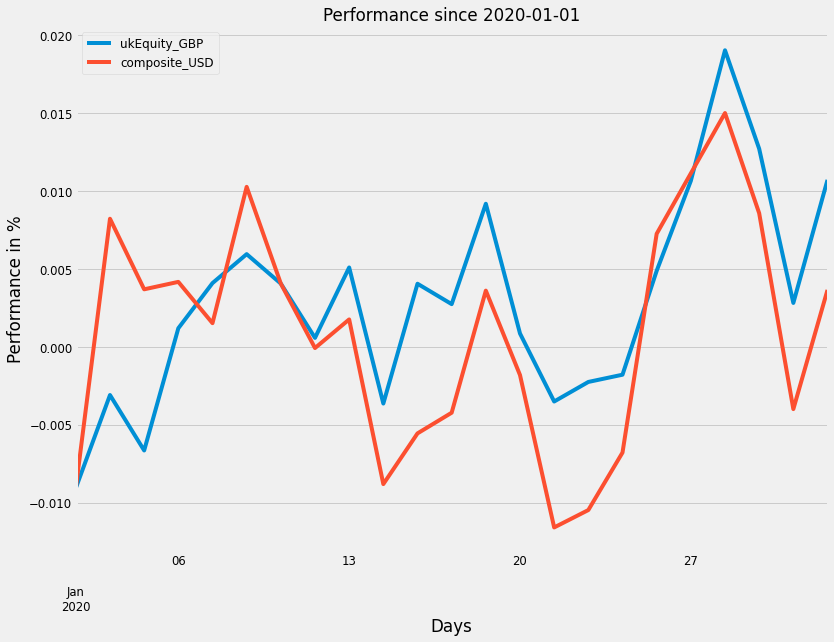

In [24]:
time_series_performance()

CLEAN UP - Delete Portfolios

In [25]:
for port in portfolio_codes:

    try:

        response = portfolios_api.delete_portfolio(scope=scope, code=port[0])
    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])